# 新型冠状病毒数据分析

丁香园实时网站：https://ncov.dxy.cn/ncovh5/view/pneumonia

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils   # some convenient functions
import matplotlib.font_manager as mfm
font_path = './STFANGSO.TTF'
font_prop = mfm.FontProperties(fname=font_path)

%load_ext autoreload
%autoreload 2

## 获取原始数据

In [2]:
data = utils.load_chinese_data()

### 查看简要信息

In [3]:
data.head(3)

,provinceName,cityName,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,city_confirmedCount,city_suspectedCount,city_curedCount,city_deadCount,updateTime,updateDate
0,甘肃省,兰州,62,0,6,0,30,0,3,0,2020-02-06 00:23:49.257,2020-02-06
1,甘肃省,天水,62,0,6,0,10,0,0,0,2020-02-06 00:23:49.257,2020-02-06
2,甘肃省,定西,62,0,6,0,5,0,1,0,2020-02-06 00:23:49.257,2020-02-06


In [4]:
print('最近更新于: ', data['updateTime'].max())
print('数据日期范围: ', data['updateDate'].min(), 'to', data['updateDate'].max())
print('数据条目数: ', data.shape[0])

最近更新于:  2020-02-06 00:23:49.257000
数据日期范围:  2020-01-24 to 2020-02-06
数据条目数:  18528


## 把实时数据整合成每日数据

In [9]:
daily_frm = utils.aggDaily(data)

In [10]:
daily_frm.tail(3)

,provinceName,cityName,confirmed,cured,dead,updateTime,updateDate
411,黑龙江省,鹤岗,2,0,0,2020-02-05 20:04:57.566,2020-02-05
412,黑龙江省,黑河,1,0,0,2020-02-05 20:04:57.566,2020-02-05
403,黑龙江省,齐齐哈尔,20,0,0,2020-02-05 20:04:57.566,2020-02-05


## 数据分析

### 全国时间序列

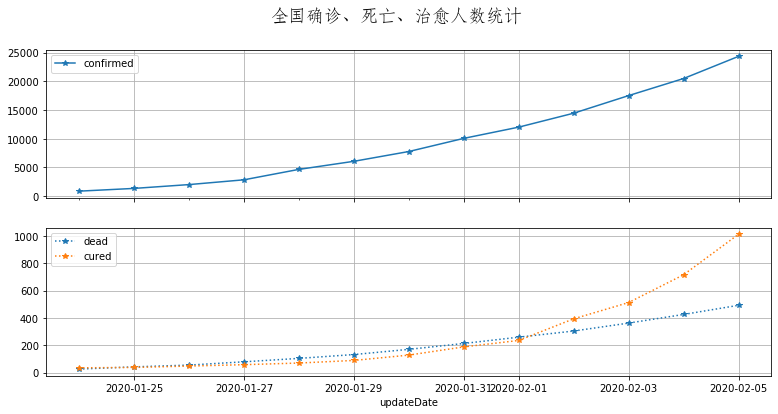

In [11]:
fig = utils.tsplot_conf_dead_cured(daily_frm, title_prefix='全国')
plt.show()

### 单个省份的时间序列也很容易

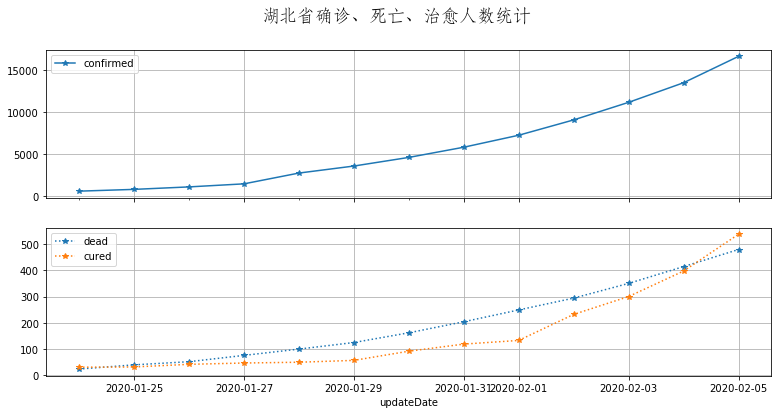

In [13]:
province = '湖北省'   # 输入你所要的省份
fig = utils.tsplot_conf_dead_cured(daily_frm[daily_frm['provinceName'] == province], title_prefix=province)
plt.show()                                  

### 单个城市用法也是一样的, 还可以使用 logy=True 画指数图，看人数是否指数增长

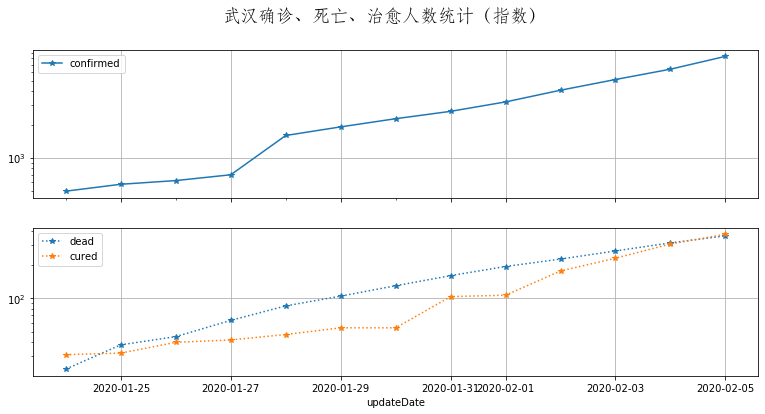

In [14]:
city = '武汉'
fig = utils.tsplot_conf_dead_cured(daily_frm[daily_frm['cityName'] == city], title_prefix=city, logy=True)
plt.show()  

## 武汉 - 湖北（除武汉外） - 湖北以外 疫情对比

In [39]:
wuhan = daily_frm[daily_frm['cityName'] == '武汉'].groupby('updateDate').agg('sum')
hubei_exWuhan = daily_frm[(daily_frm['provinceName'] == '湖北省') & (daily_frm['cityName'] != '武汉')].groupby('updateDate').agg('sum')
china_exHubei = daily_frm[daily_frm['provinceName'] != '湖北省'].groupby('updateDate').agg('sum')

contrast_frm = pd.merge(wuhan.add_suffix('_Wuhan'), hubei_exWuhan.add_suffix('_Hubei_exWuhan'), 'left', on='updateDate')
contrast_frm = pd.merge(contrast_frm, china_exHubei.add_suffix('_China_exHubei'), 'left', on='updateDate')

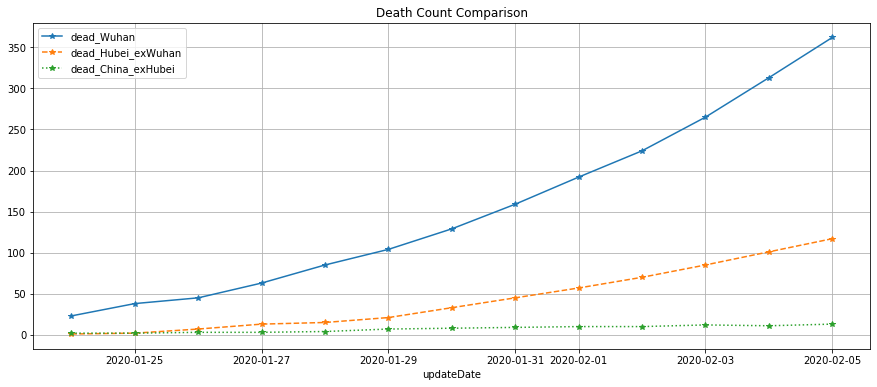

In [40]:
contrast_col = 'dead'    # you can pick other columns such as 'dead', 'cured'
locations = ('Wuhan', 'Hubei_exWuhan', 'China_exHubei')
contrast_frm.plot(y=[contrast_col + '_' + suffix for suffix in locations], grid=True, figsize=(15, 6), style=['-*', '--*', ':*'], 
                  title='Death Count Comparison')

从上图可以看出，武汉死亡人数远远超出湖北（武汉以外）以及其他全国各地死亡人数总和。这是为什么呢？一个可能原因是因为武汉确诊数目大，另一个可能原因是医疗条件饱和造成了死亡。

如果是第一个原因的话，那么死亡人数/确诊人数应该在各个区域都接近。下面检查一下这个假设：

In [41]:
for loc in locations:
    contrast_frm['simpleDeathRate_' + loc] = contrast_frm['dead_' + loc] / contrast_frm['confirmed_' + loc]

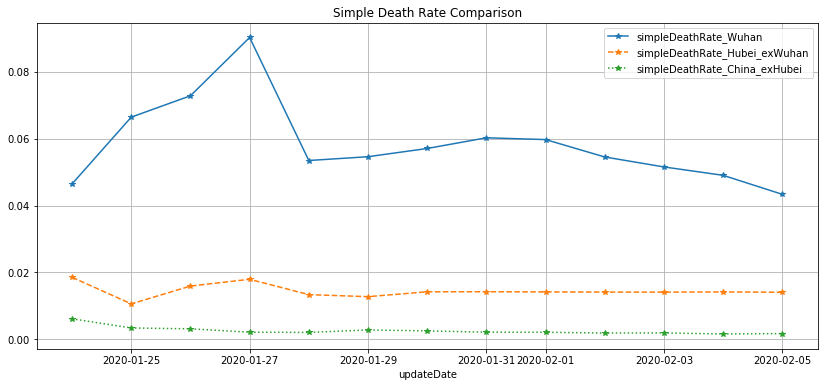

In [43]:
contrast_frm.plot(y=['simpleDeathRate_' + loc for loc in locations], grid=True, figsize=(14, 6), style=['-*', '--*', ':*'],
                 title='Simple Death Rate Comparison')

从上图可以看出，武汉死亡率 > 湖北（除武汉外）死亡率 > 全国其他地区死亡率

这说明武汉死亡人数高不是因为确诊人数多造成的。但是我们知道，死亡人数应该比确诊人数有个滞后，会不会是这个滞后造成计算不准确呢？

In [44]:
def lagDeathRate(df, location, lag=5):
    return np.mean(df['dead_' + location][lag:].to_numpy() / df['confirmed_' + location][:-lag].to_numpy())

In [45]:
print('延迟死亡率')
print('武汉：', "{:.2%}".format(lagDeathRate(contrast_frm, 'Wuhan')))
print('湖北（除武汉）：', "{:.2%}".format(lagDeathRate(contrast_frm, 'Hubei_exWuhan')))
print('全国（除湖北）：', "{:.2%}".format(lagDeathRate(contrast_frm, 'China_exHubei')))

延迟死亡率
武汉： 19.04%
湖北（除武汉）： 11.73%
全国（除湖北）： 0.85%


可见死亡统计的延迟效应并不影响 

武汉死亡率 > 湖北（除武汉外）死亡率 > 全国其他地区死亡率

的结论。

**那么是不是医疗系统饱和造成武汉、湖北死亡率高呢？**